In [2]:
!rm -rf ~/.cache/torch/transformers
!ls -als  ~/.cache/torch/transformers
!pip uninstall transformers -y
!pip uninstall torch -y
!pip install torch
!pip install transformers 

ls: cannot access /home/ec2-user/.cache/torch/transformers: No such file or directory
Found existing installation: transformers 3.5.0
Uninstalling transformers-3.5.0:
  Successfully uninstalled transformers-3.5.0
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
  Successfully uninstalled torch-1.7.0
     |████████████████████████████████| 776.7 MB 627 bytes/s a 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.3 MB 12.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
import os
import torch
import pandas as pd
import numpy as np
import warnings
from transformers import (
    AutoTokenizer, AutoModelWithLMHead,GPT2Tokenizer,GPT2LMHeadModel,
    TextDataset,DataCollatorForLanguageModeling,LineByLineTextDataset,
    Trainer, TrainingArguments,
    WEIGHTS_NAME, CONFIG_NAME
)
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
output_dir="./4-train-gpt2-es-48h-1024pos-toke-es-tweets-der"
pre_trained = "ensamblador/gpt2-es-48heads"
train_path = 'train_dataset_der.txt'
test_path = 'test_dataset_der.txt'

In [2]:
!rm -rf {output_dir}

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained(pre_trained, 
                                          #force_download=True,  
                                          cache_dir = output_dir)


tokenizer.pad_token = tokenizer.eos_token
tokenizer


#print('Train')
#!head -c 1000 {train_path}
#print('\n\nTest')
#!head -c 1000 {test_path}
#print('\n')



PreTrainedTokenizer(name_or_path='ensamblador/gpt2-es-48heads', vocab_size=50000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>', 'mask_token': '<mask>'})

In [4]:
def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=train_path,
        block_size=512
    )
    test_dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=test_path,
        block_size=512
    )
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    return train_dataset,test_dataset,data_collator
train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

In [5]:
base_index= 0
(tokenizer.decode(train_dataset[base_index+0]),
 tokenizer.decode(train_dataset[base_index+1]), 
 tokenizer.decode(train_dataset[base_index+2]), 
 tokenizer.decode(train_dataset[base_index+3]))

('#BuenasNoticias  de nuestro Pdte @sebastianpinera La #NuevaLeydeArriendos agilizará los juicios de arrendamiento y protegerá a los ciudadanos ante los arriendos a abusivos. La #NuevaLeydeArriendos también establecerá la figura de arriendo, subarriendo abusivo  Lamentablemente hoy la región recibió dos noticias que nos enlutan: el fallecimiento del fiscal Cristian Oróstica y un segundo femicidio en Lota. En nombre de la Intendencia y el Gobierno Regional envío sentidas condolencias a sus familias que están viviendo un duro momento.  Aquí la oposición hace festín con el aumento d casos Covid y escarba para aumentar las muertes artificialmente, pero el ícono d los Izquierdistas Maduro, en Vnzla. se proclama el mejor para contener la pandemia declarando sólo 4000 mil casos y 35 muertes. Ese si es cuento!  A partir de hoy y hasta el sábado tendremos un programa de Villancicos en diferentes plazas de la comuna. Los invito a las 19:30 horas, para que vayan con sus niños, mascotas y amigos. 

In [6]:
model = GPT2LMHeadModel.from_pretrained(pre_trained, 
                                        #force_download=True, 
                                        cache_dir = output_dir )

print(model.config.vocab_size, tokenizer.vocab_size)
model.resize_token_embeddings(len(tokenizer))
print(model.config.vocab_size, tokenizer.vocab_size)

training_args = TrainingArguments(
    output_dir=output_dir, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=2, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 500, # Number of update steps between two evaluations.
    logging_steps=500,
    save_steps=1000, # after # steps model is saved
    evaluation_strategy="steps",
    #fp16=True,
    dataloader_drop_last=True,
    warmup_steps=250,# number of warmup steps for learning rate scheduler
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    prediction_loss_only=True,
)

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer.model.to(device);
trainer.get_train_dataloader().pin_memory=True;
trainer.get_eval_dataloader().pin_memory=True;
#trainer.get_eval_dataloader().drop_last =True;
#trainer.get_test_dataloader().pin_memory=True;
model.config


50000 50000
50000 50000


GPT2Config {
  "_name_or_path": "ensamblador/gpt2-es-48heads",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 48,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 1,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "vocab_size": 50000
}

In [7]:
trainer.train();

Step,Training Loss,Validation Loss
500,4.051217,2.024432
1000,2.941999,1.767515
1500,2.632756,1.671493
2000,2.405606,1.647889
2500,2.265940,1.626225
3000,2.160530,1.612413
3500,2.079029,1.615013


Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?
Not all data has been set. Are you sure you passed all values?


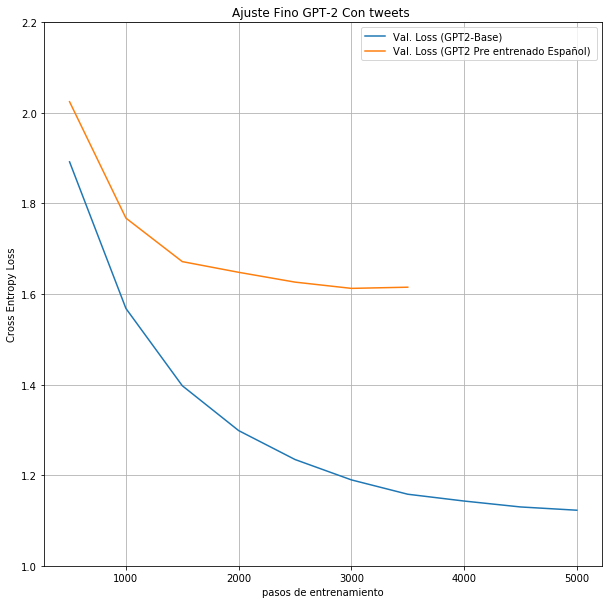

In [3]:
# Entrenamiento de modelo base GPT-2

metrics_en= np.array(
[[500,3.997869,1.891722],
[1000,3.172658,1.568079],
[1500,2.904457,1.397502],
[2000,2.743234,1.298466],
[2500,2.636571,1.234627],
[3000,2.569133,1.189672],
[3500,2.506104,1.157998],
[4000,2.46993,1.142962],
[4500,2.438746,1.129909],
[5000,2.420213,1.122694]])





# Entrenamiento de modelo base GPT-2-es-8h-512pos
metrics_es_new = np.array(
[[500,4.051217,2.024432],
[1000,2.941999,1.767515],
[1500,2.632756,1.671493],
[2000,2.405606,1.647889],
[2500,2.26594,1.626225],
[3000,2.16053,1.612413],
[3500,2.079029,1.615013]])


import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10,10))

plt.plot(metrics_en[:,0], metrics_en[:,2], label='Val. Loss (GPT2-Base)')
#plt.plot(metrics_es[:,0], metrics_es[:,2], label='Val. Loss (Token Es / Model En)')
plt.plot(metrics_es_new[:,0], metrics_es_new[:,2], label='Val. Loss (GPT2 Pre entrenado Español) ')

ax.grid()

ax.set(xlabel='pasos de entrenamiento', ylabel='Cross Entropy Loss',
       title='Ajuste Fino GPT-2 Con tweets ')
plt.yticks(np.arange(1, 2.2, step=0.2))
plt.legend()

In [8]:
trainer.save_model()

In [9]:
# creating directory if it is not present
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

# save model and model configs
model.save_pretrained(output_dir)
model_to_save.config.to_json_file(output_config_file)

# save tokenizer
tokenizer.save_pretrained(output_dir)

('./4-train-gpt2-es-48h-1024pos-toke-es-tweets-der/tokenizer_config.json',
 './4-train-gpt2-es-48h-1024pos-toke-es-tweets-der/special_tokens_map.json',
 './4-train-gpt2-es-48h-1024pos-toke-es-tweets-der/vocab.json',
 './4-train-gpt2-es-48h-1024pos-toke-es-tweets-der/merges.txt',
 './4-train-gpt2-es-48h-1024pos-toke-es-tweets-der/added_tokens.json')

## Probando el modelo

In [22]:
#output_dir="./ensamblador-tweets"
model = AutoModelWithLMHead.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(pre_trained)

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [12]:
bad_words_ids =[ 
    tokenizer.encode('|', add_prefix_space=True)]


def test_model(device, model, text):
    input_ids = tokenizer.encode(text, return_tensors='pt').to(device) # getting out output
    #attention_mask = tokenizer.encode(seeds, return_tensors='pt').to(device)
    
    print("generando beams para input: ", text,"\n==================================================")
    beam_output = model.generate(
        input_ids,
        max_length = 190,
        min_length = 50,
        early_stop=True,
        do_sample=True,
        top_k=100, 
        top_p=0.9,
        num_beams = 10,
        bad_words_ids = bad_words_ids,
        temperature = 1,
        #length_penalty=2,
        no_repeat_ngram_size=2,
        #repetition_penalty=2.0,
        num_return_sequences=10,
        bos_token_id = tokenizer.bos_token_id,
        eos_token_id = tokenizer.eos_token_id,
        pad_token_id =tokenizer.pad_token_id
    )
    
    decoded_beams = []
    
    
    for beam in beam_output:   
        decoded_beams.append({'text':text, 'generado':tokenizer.decode(beam)})
        #print ("\n\n",tokenizer.decode(beam))
        
    return decoded_beams

In [13]:
generated = test_model(device, model, "Con los vecinos ")

generando beams para input:  Con los vecinos  


In [14]:
pd.DataFrame.from_records(generated)

,text,generado
0,Con los vecinos,"Con los vecinos 👍 #CuidaTuVida El @MinDesarrollo presentó la página, para consultar por el pago del #IngresoDeEmergencia, una importante ayuda en la pandemia de #COVID19. Recuerda que ya no es necesaria la #ClaveUnica para solicitar este beneficio. La #cuarentena en Colina se extiende hasta el viernes 17 de junio. Reiteramos las medidas más importantes para cuidarse frente al #Covid19: #LavateLasManos #QuedateEnCasa #UsaMascarilla [AHORA] Gobernadora de San Pedro, María Paz Santelices, junto a la Alcaldesa de la comuna, Carmen Bou, hacen entrega de cajas de mercadería #AlimentosParaChile, para ayudar a las familias más afectadas por esta pandemia. #PlanCoronaVirus #RMdeTodos✅ #ChileEnMarcha En"
1,Con los vecinos,"Con los vecinos 👍 #ColinaSomosTodos Ahora son tres formas de donar a quien lo necesita: arma tu caja y entrégala en la oficina de Los Ingleses; llámanos y recogemos tu bolsa en tu casa; o entra a y sigue el link para comprar una caja en sencillos pasos. @mario_olavarria ⏰A esta hora, Gob.@RAMIREZCHILE participa en #Tedeum Evangélico, en marco del #GobiernoEnTerreno de la Provincia de #Melipilla por #FiestasPatrias2019. #RMdeTodos✅ #ChileEnPapudo [AHORA] El Alcalde Manuel Devia, junto a los Gobernadores y Seremis, participan de una nueva sesión del Sistema Táctico de Operación Policial (STOP), con el objetivo de resguardar la seguridad"
2,Con los vecinos,"Con los vecinos @LC_Decom [AHORA] Autoridades de la Gobernación de Maipo recorren las calles de #SanBernardo entregando comida caliente a las personas en situación de calle. #QuedateEnCasa #Covid_19 #PlanCoronavirus #CuidémonosEntreTodos #SeguimosAvanzando con las cajas de alimento del programa #AlimentosParaChile, iniciativa del Gobierno del Pdte. Piñera, para ayudar a más familias de clase media en medio de crisis sanitaria por el #COVIDー19. 👉 Hoy nos reunimos con el Ministro de Salud, Enrique Paris, con quien analizamos el proyecto de Integración Social, que beneficiará a cerca de 1,5 millones de personas del país. Más info en ➡️ #ChileEnMarcha ⭕ El #MercadoCampesino ya cuenta con"
3,Con los vecinos,"Con los vecinos 👍 #CuidaTuVida Si estás buscando un regalo para tu papá, te invitamos a la Vitrina Virtual del #CentroDelEmprendedor para el #DiaDelPadre. Encuentra ese obsequio perfecto para este día tan especial. Te dejamos también a algunos participantes (3 de 3). @mario_olavarria El #MercadoCampesino ya cuenta con la aplicación YoiFerias, donde puedes conocer sobre los productos que puedes encontrar, los precios y días que están disponibles. Entra a y comienza a usarla. [AHORA] Gobernadora (s) de la Provincia de Maipo, María Paz Santelices, junto al Alcalde de #SanPedro #JuanPabloBarros y autoridades locales, participan de una nueva sesión del Sistema Táctico de Operación Policial. #ChileLoHacemosTodos Hoy se conmemora el Día Nacional de"
4,Con los vecinos,"Con los vecinos 👍 #CuidaTuVida Te dejamos los días y horarios de atención de #DIDECOEnTuBarrio, en las sedes de las juntas de vecinos. Recuerda que debes asistir con tu permiso de, con mascarilla y manteniendo la distancia. Cupos limitados. @mario_olavarria Gobernación Melipilla Informa: A esta hora, informamos sobre los servicios públicos que se encuentran habilitados y en funcionamiento para este Viernes 26 de Noviembre en la comuna. #CentroDeApoyoAVíctimas, #Providencia y #Cantón, de lunes a viernes entre 9:00 y 12:30hrs. ➡️ En el Gob. del Pdte.@sebastianpinera estamos comprometidos con el desarrollo de la #RMdeTodos✅ y con la seguridad de todos los chilenos y chilenos. Con"
5,Con los vecinos,"Con los vecinos 👍 #CuidaTuVida El @MinDesarrollo presentó la página, para consultar por el pago del #IngresoDeEmergencia, una importante ayuda en la pandemia de #COVID19. Recuerda que ya no es necesaria la #ClaveUnica para solicitar el #PermisoDeCirculacion en línea en ; recuerda que hasta el 30 de junio puedes pagar la primera cuota. Si necesitas ayuda consulta en los teléfonos 2270733

In [15]:
generated

[{'text': 'Con los vecinos ',
  'generado': 'Con los vecinos 👍  #CuidaTuVida El @MinDesarrollo presentó la página, para consultar por el pago del #IngresoDeEmergencia, una importante ayuda en la pandemia de #COVID19. Recuerda que ya no es necesaria la #ClaveUnica para solicitar este beneficio.  La #cuarentena en Colina se extiende hasta el viernes 17 de junio. Reiteramos las medidas más importantes para cuidarse frente al #Covid19: #LavateLasManos #QuedateEnCasa #UsaMascarilla  [AHORA] Gobernadora de San Pedro, María Paz Santelices, junto a la Alcaldesa de la comuna, Carmen Bou, hacen entrega de cajas de mercadería #AlimentosParaChile, para ayudar a las familias más afectadas por esta pandemia. #PlanCoronaVirus #RMdeTodos✅ #ChileEnMarcha  En'},
 {'text': 'Con los vecinos ',
  'generado': 'Con los vecinos 👍  #ColinaSomosTodos Ahora son tres formas de donar a quien lo necesita: arma tu caja y entrégala en la oficina de Los Ingleses; llámanos y recogemos tu bolsa en tu casa; o entra a  y 

In [43]:
generated2 = test_model(device, model, "Vamos con todo ")

generando beams para input:  Vamos con todo  


In [44]:
generated2

[{'text': 'Vamos con todo ',
  'generado': 'Vamos con todo 🇨�  #CuidaTuVida DIDECO va a tu barrio: Un nuevo servicio para que hagas consultas y resuelvas tus dudas sobre esta dirección del municipio. Solo se atenderá con permiso de, con mascarilla y manteniendo la distancia. Cupos limitados. @mario_olavarria  En el #DiaMundialContraElCoronavirus, el Int.@UrquietaAtacama junto al Jefe de la Defensa Nacional, Gral. Heyermann, dieron a conocer el primer caso de contagio en la comuna de #Copiapó. Te invitamos a ver el vídeo:  ➡️ #PlanDeInviernoSeguro Para que el invierno no te pille desprevenido, te dejamos algunos consejos que puedes aplicar para tener tu casa segura y así te cuides y a tus mascotas. Más info en⤵�'},
 {'text': 'Vamos con todo ',
  'generado': 'Vamos con todo 💪  #ColinaSomosTodos Ahora son tres formas de donar a quien lo necesita: arma tu caja y entrégala en la oficina de Los Ingleses; llámanos y recogernos en tu casa; o entra a  y sigue el link para comprar una caja en se

In [45]:
generated3 = test_model(device, model, "El 27 de enero del año 2010 ")

generando beams para input:  El 27 de enero del año 2010  


In [46]:
generated3

[{'text': 'El 27 de enero del año 2010 ',
  'generado': 'El 27 de enero del año 2010 @ministeriosalud entregó balance #COVID_19: 4.641 casos nuevos; 3.054, en total. 9 fallecidos; 50.708 exámenes PCR; 354.842 en la UCI. 1.951 VM; 372 estado crítico.  REPORTE EN:  🔹️OPORTUNIDAD LABORAL: Empresa Agroservicios MVC, requiere contratar para sus trabajos a un costado de la empresa CGE, para que realice trabajos de reparación de maquinaria y reposición de las parrillas de aguas servidas en el lugar.…  #CuidaTuVida Si estás buscando un regalo para tu papá, te invitamos a la Vitrina Virtual del #CentroDelEmprendedor para el #DiaDelPadre. Encuentra ese obsequio perfecto para este día tan especial. Te'},
 {'text': 'El 27 de enero del año 2010 ',
  'generado': 'El 27 de enero del año 2010 🔴 A esta hora, Gob. @RAMIREZCHILE recibe a los vecinos de la Provincia de #Melipilla, en el marco del programa #PlanVeterinarioEnTerreno, financiado por la #Subdere. #RMdeTodos✅  #CuidémonosEntreTodos  El #Mercad

In [47]:
generated4 = test_model(device, model, "El presidente  ")

generando beams para input:  El presidente   


In [48]:
generated4

[{'text': 'El presidente  ',
  'generado': 'El presidente  @sebastianpinera anunció el plan de desconfinamiento gradual Paso a Paso #NosCuidamos que beneficiará a miles de familias de la #RMdeTodos. El Int.@UrquietaAtacama junto a la Seremi(s)@KimFaBondi, y diversas autoridades hicieron entrega de este importante apoyo a las familias que más lo necesitan.🙌  El #MercadoCampesino ya cuenta con la aplicación YoiFerias, donde puedes conocer sobre los productos que puedes encontrar, los precios y días que están disponibles. Entra a  y comienza ya a usarla. Te dejamos también un video explicativo. #ColinaSomosTodos Ahora son tres formas de donar a quien lo necesita: arma tu arma y entrégala en la oficina de Los Ingleses; llámanos y recogemos tu caja en tu casa; o entra a y sigue'},
 {'text': 'El presidente  ',
  'generado': 'El presidente  @sebastianpinera promulgó la ley de #ProtecciónDelEmpleo, una importante ayuda en la pandemia del #COVID19. Revisa más info aquí⤵️  #CuidémonosEntreTodos 

In [11]:
model.config

GPT2Config {
  "_name_or_path": "ensamblador/gpt2-es-48heads",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 48,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 1,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "vocab_size": 50000
}

In [16]:
with open(test_path, 'r') as f:
    test = f.read()

with open(train_path, 'r') as g:
    train = g.read()

    
    
len(train),len(test)

(5690881, 1006141)

In [18]:
encodings_test = tokenizer(test, return_tensors='pt')
encodings_train = tokenizer(train, return_tensors='pt')

In [19]:
max_length = 512 #model.config.n_positions
stride = 256

lls = []
for i in range(0, encodings_test.input_ids.size(1), stride):
    begin_loc = max(i + stride - max_length, 0)
    end_loc = min(i + stride, encodings_test.input_ids.size(1))
    trg_len = end_loc - i    # may be different from stride on last loop
    input_ids = encodings_test.input_ids[:,begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:,:-trg_len] = -100
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        log_likelihood = outputs[0] * trg_len
    lls.append(log_likelihood)
ppl_test = torch.exp(torch.stack(lls).sum() / end_loc)



lls = []
for i in range(0, encodings_train.input_ids.size(1), stride):
    begin_loc = max(i + stride - max_length, 0)
    end_loc = min(i + stride, encodings_train.input_ids.size(1))
    trg_len = end_loc - i    # may be different from stride on last loop
    input_ids = encodings_train.input_ids[:,begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:,:-trg_len] = -100
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        log_likelihood = outputs[0] * trg_len
    lls.append(log_likelihood)
ppl_train = torch.exp(torch.stack(lls).sum() / end_loc)

In [20]:
ppl_test.tolist(), ppl_train.tolist()

(18.019954681396484, 8.288548469543457)

In [21]:
np.log(ppl_test.tolist()),np.log(ppl_train.tolist())

(2.891479737271174, 2.1148748596720988)